In [1]:
import pandas as pd
import numpy as np
import os
import sys

parent_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
helper_path = os.path.join(parent_path, "Data_Workflow")
sys.path.append(helper_path)
from DataHelper import *

TARGET = "total load actual"
BM = "total load forecast"
PCA_n_components = 20

os.chdir("../Data/Selected_Features")
df = pd.read_csv("raw_all_features_dataset.csv")
df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("CET")
df.set_index("time", inplace=True)

train, validation, test = split_train_test_validation(df, df.index)
train_start, train_end, valid_start, valid_end, test_start, test_end =  train.index[0], train.index[-1], validation.index[0], validation.index[-1], test.index[0], test.index[-1]
print(f"Training set starts at {train_start} and ends at {train_end}.")
print(f"Validation set starts at {valid_start} and ends at {valid_end}")
print(f"Testing set starts at {test_start} nd ends at {test_end}")

X_features = df.columns.copy().tolist()
X_features.remove(TARGET)

os.chdir("..")
bm_df = pd.read_csv("load_benchmark.csv")
bm_df["time"] = pd.to_datetime(bm_df["time"], utc=True).dt.tz_convert("CET")
bm_df.set_index("time", inplace=True)

os.chdir("../Models/Results")

Training set starts at 2015-01-01 00:00:00+01:00 and ends at 2017-10-19 16:00:00+02:00.
Validation set starts at 2017-10-19 17:00:00+02:00 and ends at 2018-05-26 20:00:00+02:00
Testing set starts at 2018-05-26 21:00:00+02:00 nd ends at 2018-12-31 23:00:00+01:00


For the modelling part, we will be applying three deep neural networks. Specifically, we will be using LSTM, Stacked LSTM, and CNN LSTM.

# 1.0 Process Data

To optimize our model's performance, we will first apply Principal Component Analysis (PCA) to reduce the dimensionality of the dataset. Specifically, we will reduce the dataset to 20 principal components. This step helps eliminate redundant features and noise while retaining the most critical patterns in the data. After transforming the data using PCA, we will apply a min-max scaler fitted on the training set and subsequently applied to the entire dataset to normalize the feature values.

After these transformations, we will create sliding windows to prepare the data for model training. Each sliding window will consist of 48 consecutive hours of data, which will be used to predict the target value for the 49th hour. This allows the model to learn temporal dependencies and capture patterns over two-day periods, enabling it to make informed predictions.

For each window, the target variable (total load actual) is shifted by 1 hour. This means that after using a 48-hour window to predict the 49th hour, the window will shift forward by one hour to create the next training sample. This method ensures the model captures sequential patterns and uses past data to make hourly predictions.

By leveraging PCA for dimensionality reduction and the sliding window approach for time series forecasting, this pipeline efficiently captures the temporal dynamics of the dataset, enhancing both the model's computational efficiency and its ability to generalize to future predictions.

In [2]:
processed_df, processed_index, min_val, max_val = model_data_process(df, TARGET, train_end, X_features, PCA_n_components)

predict_window = 48 # Number of past hours used to predict future
hourly_steps = 1 # Number of hour(s) to predict

X_train, y_train = DNN_create_sliding_windows(processed_df, processed_index, train_start, train_end, predict_window, hourly_steps)
X_valid, y_valid = DNN_create_sliding_windows(processed_df, processed_index, valid_start, valid_end, predict_window, hourly_steps)
X_test, y_test = DNN_create_sliding_windows(processed_df, processed_index, test_start, test_end, predict_window, hourly_steps)

train, valid = DNN_shuffle_batch((X_train, y_train), (X_valid, y_valid))

# 2.0 LSTM

In [3]:
single_history = fit_lstm(X_train, train, valid, "../")

Epoch 1/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0525 - root_mean_squared_error: 0.2169
Epoch 1: val_loss improved from inf to 0.00937, saving model to ../lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0524 - root_mean_squared_error: 0.2167 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968 - learning_rate: 6.0000e-04
Epoch 2/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0146 - root_mean_squared_error: 0.1205
Epoch 2: val_loss did not improve from 0.00937
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0146 - root_mean_squared_error: 0.1205 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1020 - learning_rate: 7.2514e-04
Epoch 3/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935
Epoch 3: val_loss improved from 0.00937 to 0.00608, saving model to ../lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0061 - val_root_mean_squ

File is saved.


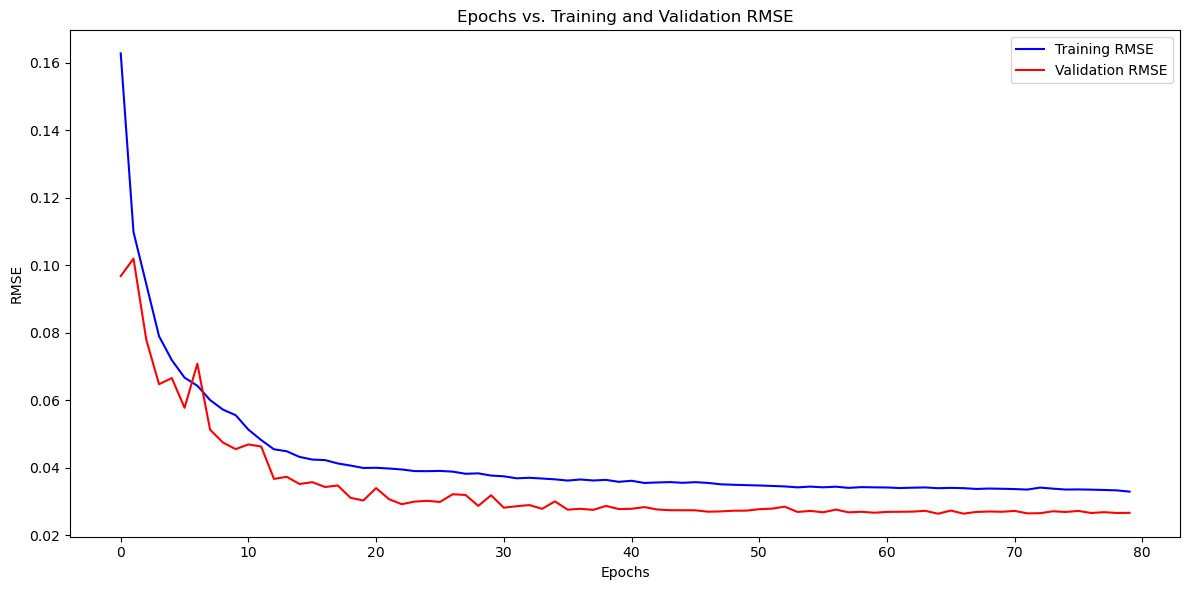

In [4]:
plot_model_rmse(single_history, "../History/lstm.csv")

In [5]:
lstm_results, lstm_predictions = DNN_predict(X_test, y_test, TARGET, min_val, max_val, "../lstm.keras")
lstm_preds_df = pd.DataFrame(lstm_predictions, index=test.index[predict_window:], columns=["Results"])
save_file(lstm_preds_df, "lstm_pred.csv")
lstm_results

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 100)        │        48,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │       720,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,076,406 (11.74 MB)

 Trainable params: 769,101 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,307,305 (8.80 MB)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
File is saved.


,MSE,RMSE,MAE,MAPE
0,326609.826489,571.49788,373.613047,1.312597


# 3.0 Stacked LSTM

In [6]:
stacked_history = fit_stacked_lstm(X_train, train, valid, "../")

Epoch 1/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0420 - root_mean_squared_error: 0.1993
Epoch 1: val_loss improved from inf to 0.00974, saving model to ../stacked_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 0.0420 - root_mean_squared_error: 0.1992 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0987 - learning_rate: 0.0010
Epoch 2/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0113 - root_mean_squared_error: 0.1059
Epoch 2: val_loss improved from 0.00974 to 0.00778, saving model to ../stacked_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0113 - root_mean_squared_error: 0.1059 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882 - learning_rate: 0.0012
Epoch 3/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887
Epoch 3: val_loss did not improve from 0.00778
765/765 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0107 - val_root_

File is saved.


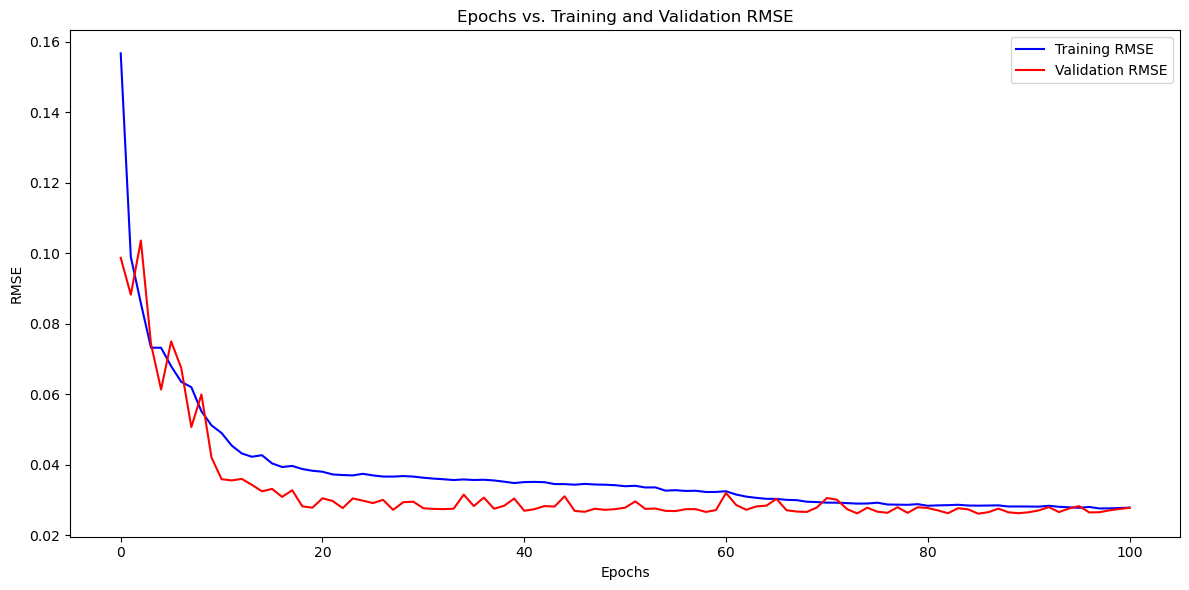

In [7]:
plot_model_rmse(stacked_history, "../History/stacked_lstm.csv")

In [8]:
stacked_lstm_results, stacked_lstm_predictions = DNN_predict(X_test, y_test, TARGET, min_val, max_val, "../stacked_lstm.keras")
slstm_preds_df = pd.DataFrame(stacked_lstm_predictions, index=test.index[predict_window:], columns=["Results"])
save_file(slstm_preds_df, "stacked_lstm_pred.csv")
stacked_lstm_results

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 48, 200)        │       177,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 48, 100)        │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       480,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,112,806 (11.87 MB)

 Trainable params: 778,201 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,334,605 (8.91 MB)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
File is saved.


,MSE,RMSE,MAE,MAPE
0,347099.976827,589.151913,385.250947,1.350066


# 4.0 CNN LSTM

In [9]:
cnn_lstm_history = fit_cnn_lstm(X_train, train, valid, "../")

Epoch 1/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0409 - root_mean_squared_error: 0.1974
Epoch 1: val_loss improved from inf to 0.01687, saving model to ../cnn_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.0409 - root_mean_squared_error: 0.1974 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299 - learning_rate: 0.0010
Epoch 2/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134
Epoch 2: val_loss improved from 0.01687 to 0.01264, saving model to ../cnn_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 0.0129 - root_mean_squared_error: 0.1133 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124 - learning_rate: 0.0012
Epoch 3/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898
Epoch 3: val_loss improved from 0.01264 to 0.00586, saving model to ../cnn_lstm.keras
765/765 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898

File is saved.


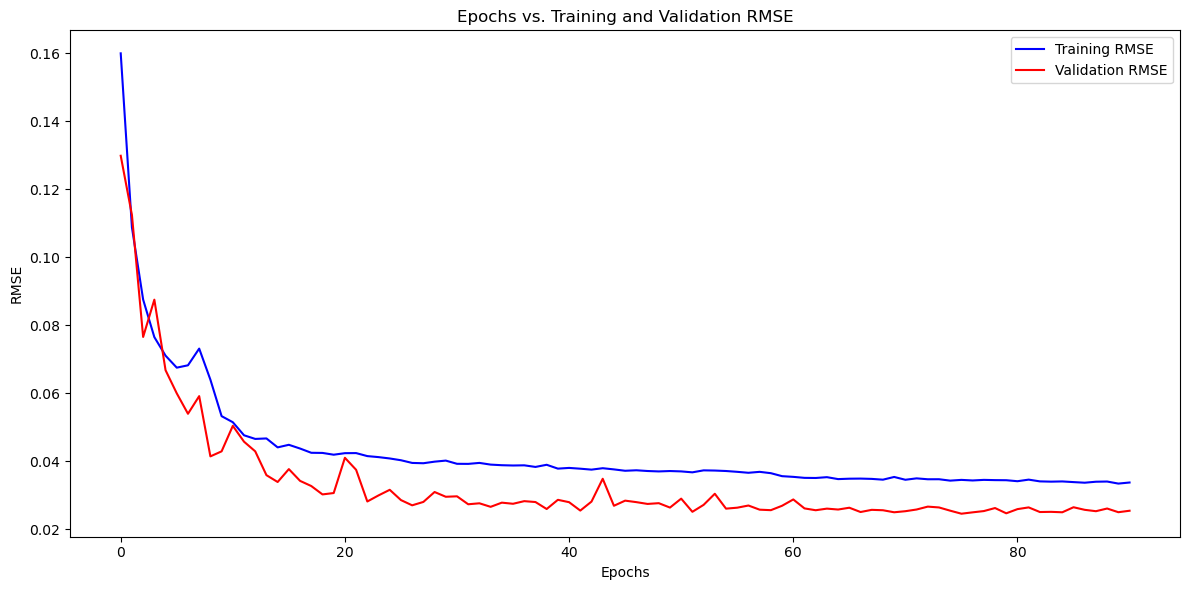

In [10]:
plot_model_rmse(cnn_lstm_history, "../History/cnn_lstm.csv")

In [11]:
cnn_lstm_results, cnn_lstm_predictions = DNN_predict(X_test, y_test, TARGET, min_val, max_val, "../cnn_lstm.keras")
cnnlstm_preds_df = pd.DataFrame(cnn_lstm_predictions, index=test.index[predict_window:], columns=["Results"])
save_file(cnnlstm_preds_df, "cnn_lstm_pred.csv")
cnn_lstm_results

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 48, 150)        │       129,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 48, 100)        │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │       480,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,849,414 (10.87 MB)

 Trainable params: 712,353 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,137,061 (8.15 MB)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
File is saved.


,MSE,RMSE,MAE,MAPE
0,295282.015955,543.398579,357.193821,1.260254


# 5.0 Final Notes

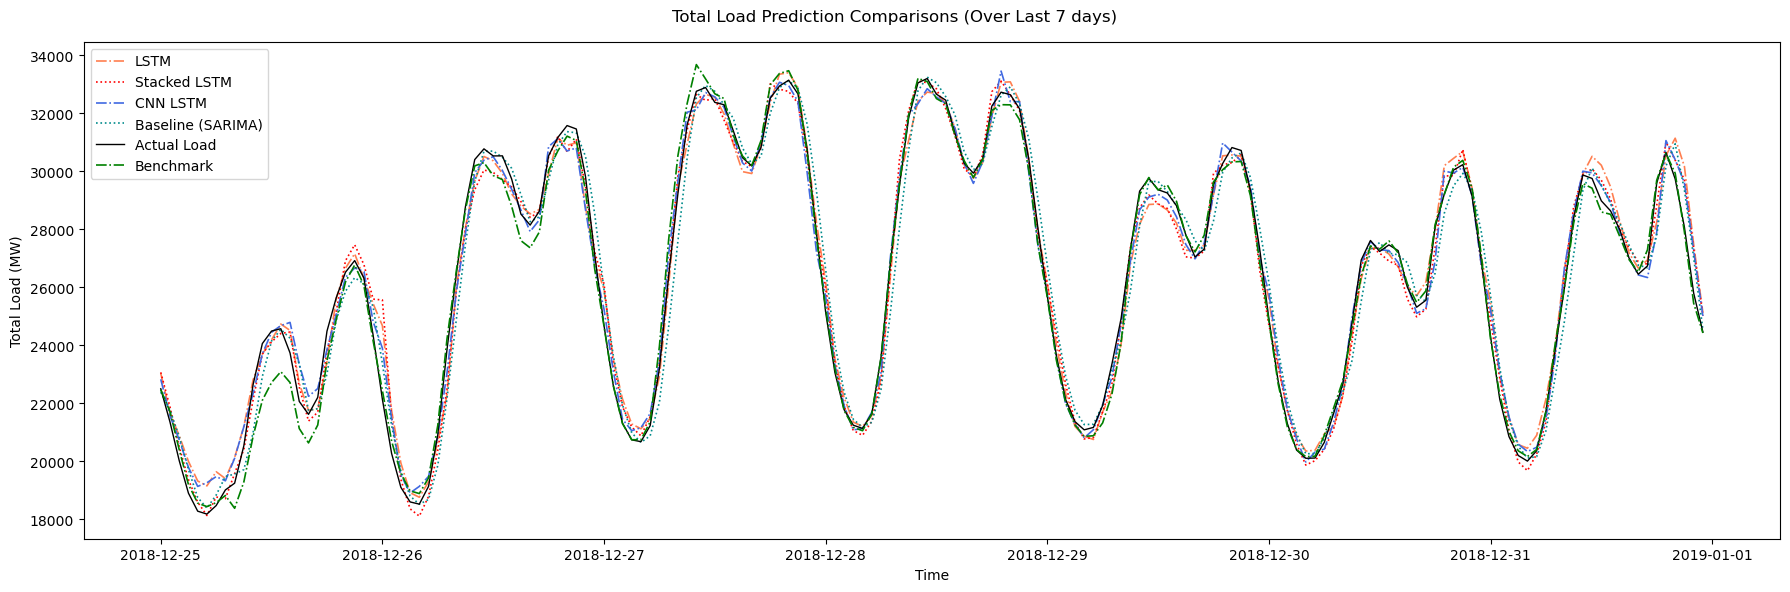

,MSE,RMSE,MAE,MAPE
LSTM,326609.830651,571.497883,373.613054,1.312597
Stacked LSTM,347099.977606,589.151914,385.250954,1.350066
CNN LSTM,295282.027680,543.398590,357.193819,1.260254
Baseline (SARIMA),772077.950824,878.679663,601.006380,2.118588
Benchmark,154486.870875,393.048179,257.940330,0.886564


In [12]:
lstm_pred_df = pd.read_csv("lstm_pred.csv")
stacked_lstm_pred_df = pd.read_csv("stacked_lstm_pred.csv")
cnn_lstm_history_lstm_pred_df = pd.read_csv("cnn_lstm_pred.csv")
baseline_df = pd.read_csv("baseline_pred.csv")
actual_df = bm_df[[TARGET]].reset_index()
forecast_df = bm_df[[BM]].reset_index()

model_prediction_dfs = {"LSTM": lstm_pred_df, "Stacked LSTM": stacked_lstm_pred_df, "CNN LSTM": cnn_lstm_history_lstm_pred_df, "Baseline (SARIMA)": baseline_df, "Actual Load": actual_df,"Benchmark": forecast_df}
for model_name, df in model_prediction_dfs.items():
    df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("CET")
    df.set_index("time", inplace=True)
prediction_df = pd.concat(list(model_prediction_dfs.values()), axis=1)
prediction_df.dropna(inplace=True)
prediction_df.columns = list(model_prediction_dfs.keys())

n = 7
window = -24*n # last n days starting from the last hourly period
plot_linegraphs_target(prediction_df.iloc[window:], prediction_df.columns, "Actual Load", "Time", "Total Load (MW)", f"Total Load Prediction Comparisons (Over Last {n} days)", colours=['coral', 'red', 'royalblue', "darkcyan", "green"])

df_evaluation = list(map(lambda i: evaluate_model(prediction_df["Actual Load"], prediction_df[i], False, [i]), ["LSTM", "Stacked LSTM", "CNN LSTM", "Baseline (SARIMA)", "Benchmark"]))
df_evaluation = pd.concat(df_evaluation, axis=0)
df_evaluation


We implemented three deep learning models—LSTM, Stacked LSTM, and CNN LSTM—and compared them against a SARIMA baseline and a benchmark forecast from another source. The goal was to outperform the benchmark forecast, but unfortunately, none of the deep learning methods managed to surpass the benchmark in terms of accuracy.

The benchmark model achieved the lowest error across all key metrics, including Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). Specifically, the benchmark's MSE of 154,486 and RMSE of 393.05 significantly outperformed the DNN models, whose RMSE ranged from 577.16 to 597.88.

Despite this, the LSTM-based models still performed reasonably well, with errors close to each other. Among the deep learning models, the Stacked LSTM had the best performance, with an RMSE of 577.16 and a MAPE of 1.33%, marginally outperforming the CNN LSTM and standard LSTM. These results suggest that while deep learning models were not able to beat the benchmark, they still provided decent forecasting accuracy, especially compared to the SARIMA model, which had the highest error metrics.

In conclusion, while the benchmark model remains the most accurate in this scenario, the DNN methods did not perform too poorly and offer valuable insights for further tuning and exploration.

**Note:** All three models appear to be underfitting the training data. We can address this by increasing model complexity (e.g., stacking additional LSTM layers or increasing the number of neurons in each layer), lowering the initial learning rate or the rate at which it increases after each epoch, and experimenting with different batch sizes.